In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import rotate
from pytomography.utils import rotate_detector_z
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# Last Time

We implemented $g=Hf$ on an object $f$ and for the case of a system matrix $H$ that doesn't model any phenomena

In [4]:
x = torch.linspace(-1,1,128)
xv, yv, zv = torch.meshgrid(x,x,x, indexing='ij')
obj = (xv**2 + 0.9*zv**2 < 0.5) * (torch.abs(yv)<0.8)
obj = obj.to(torch.float).unsqueeze(dim=0)

angles = torch.arange(0,360.,3)
image = torch.zeros((1,len(angles),128,128))
for i,angle in enumerate(angles):
    object_i = rotate_detector_z(obj,angle)
    image[:,i] = object_i.sum(axis=1)

Text(0, 0.5, 'r')

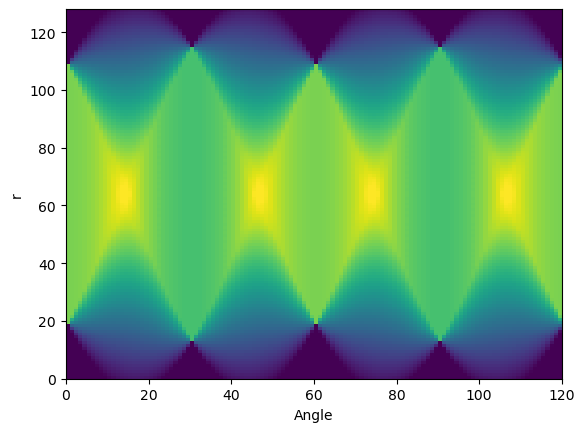

In [5]:
plt.pcolormesh(image[0,:,:,64].T)
plt.xlabel('Angle')
plt.ylabel('r')

# This Time

We'll talk about how to model $\hat{f} = H^T g$ for the same operator $H$. This time, we'll start by creating an empty object. I claim that the following implements back projection from a single angle:

In [6]:
image.shape

torch.Size([1, 120, 128, 128])

In [9]:
image[:,0].shape # 0 to 119 these are the 120 projections

torch.Size([1, 128, 128])

In [11]:
image[:,0].unsqueeze(dim=1).shape #this adds the batch required by pytorch

torch.Size([1, 1, 128, 128])

In [12]:
bp_single_angle = torch.ones([1, 128, 128, 128]) * image[:,0].unsqueeze(dim=1)

**Example**: If forward projection is

$$\begin{bmatrix} 1&1&1&0&0&0 \\ 0&0&0&1&1&1 \end{bmatrix} \begin{bmatrix} 2 \\ 3 \\ 1 \\ 4 \\ 5 \\ 6 \end{bmatrix} = \begin{bmatrix} 6 \\ 15 \end{bmatrix} $$

then back projection is

$$\begin{bmatrix} 1&0 \\ 1&0 \\1&0 \\ 0&1 \\ 0&1\\ 0&1\end{bmatrix} \begin{bmatrix} 6 \\ 15 \end{bmatrix} = \begin{bmatrix} 6 \\ 6 \\ 6 \\ 15 \\ 15 \\ 15 \end{bmatrix}$$

So there is an element of duplication going on.

In [13]:
bp_single_angle.shape  #has the same shape than original object

torch.Size([1, 128, 128, 128])

In [14]:
obj.shape

torch.Size([1, 128, 128, 128])

Nopw I need to back project for each angle, and rotate the coordinate system back to the original object coordinate axes, and add everything together

In [15]:
obj_bp = torch.zeros([1, 128, 128, 128])
for i,angle in enumerate(angles):
    bp_single_angle = torch.ones([1, 128, 128, 128]) * image[:,i].unsqueeze(dim=1)
    bp_single_angle = rotate_detector_z(bp_single_angle, angle, negative=True)
    obj_bp += bp_single_angle

Just like we did for `obj` in tutorial 1, we'll look at different projections for `obj_bp`

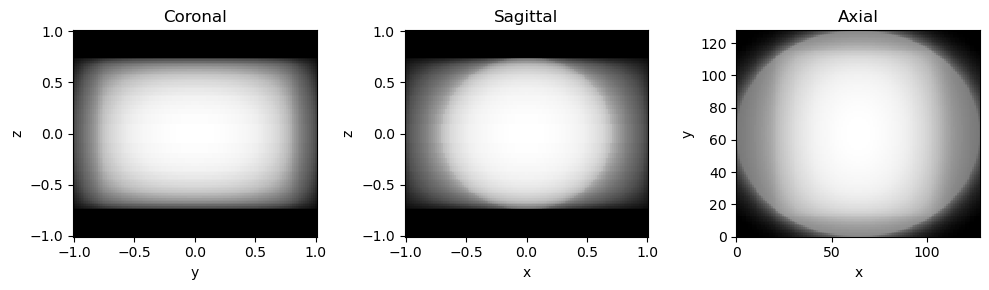

In [16]:
fig, _ = plt.subplots(1,3,figsize=(10,3))
plt.subplot(131)
plt.pcolormesh(x,x,obj_bp[0].sum(axis=0).T, cmap='Greys_r')
plt.xlabel('y')
plt.ylabel('z')
plt.title('Coronal')
plt.subplot(132)
plt.pcolormesh(x,x,obj_bp[0].sum(axis=1).T, cmap='Greys_r')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Sagittal')
plt.subplot(133)
plt.pcolormesh(obj_bp[0].sum(axis=2).T, cmap='Greys_r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Axial')
fig.tight_layout()

Clearly theres some blurring going on: $H^T g$ does **not** give the original object $f$ (if it did, then our job would be easy, and there'd be no need for reconstruction algorithms).